# Detect chessboard

In [1]:
import multicam_calibration as mcc

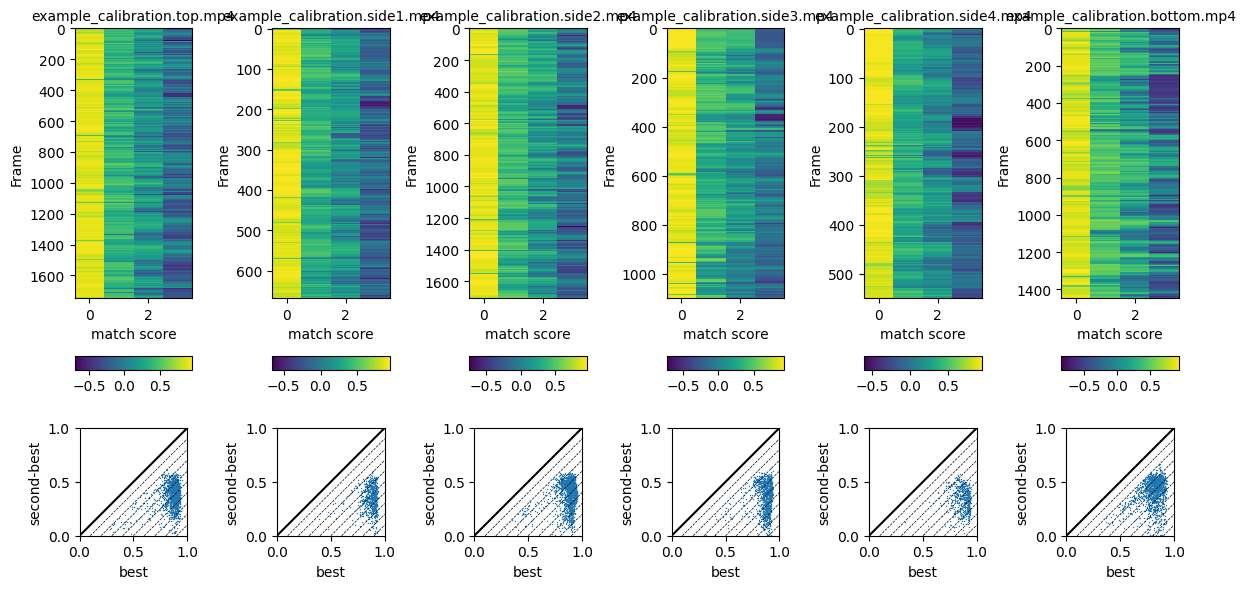

In [2]:
board_shape = (5,7)
square_size = 12.5

camera_names = ['top', 'side1', 'side2', 'side3', 'side4', 'bottom']
prefix = '../../tests/example_data/example_calibration'
video_paths = [f'{prefix}.{camera}.mp4' for camera in camera_names]

# detect calibration object in each video
all_calib_uvs, all_img_sizes = mcc.run_calibration_detection(
    video_paths, mcc.detect_chessboard, n_workers=6,
    detection_options=dict(board_shape=board_shape, scale_factor=0.5))

# display a table with the detections shared between camera pairs
mcc.summarize_detections(all_calib_uvs)

# plot corner-match scores for each frame
fig = mcc.plot_chessboard_qc_data(video_paths)

# optionally generate overlay videos
# for p in video_paths:
#     mcc.overlay_detections(p)


# Calibrate

## Initialization

In [3]:
calib_objpoints = mcc.generate_chessboard_objpoints(board_shape, square_size)

all_extrinsics, all_intrinsics, calib_poses, spanning_tree = mcc.calibrate(
    all_calib_uvs, all_img_sizes, calib_objpoints, root=0, n_samples_for_intrinsics=100)


Estimating camera intrinsics


100%|█████████████████████████████████████| 6/6 [01:00<00:00, 10.12s/it]


Initializing calibration object poses


100%|█████████████████████████████████████| 6/6 [00:02<00:00,  2.21it/s]

Estimating camera extrinsics
Merging calibration object poses


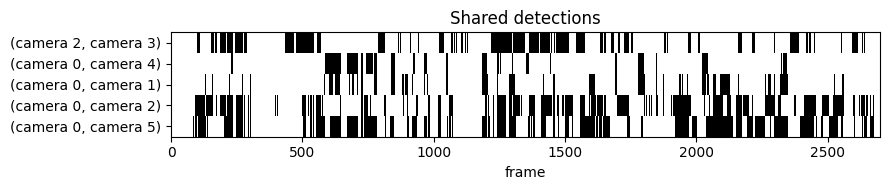

In [25]:
fig, shared_detections = plot_shared_detections(all_calib_uvs, spanning_tree)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.58it/s]


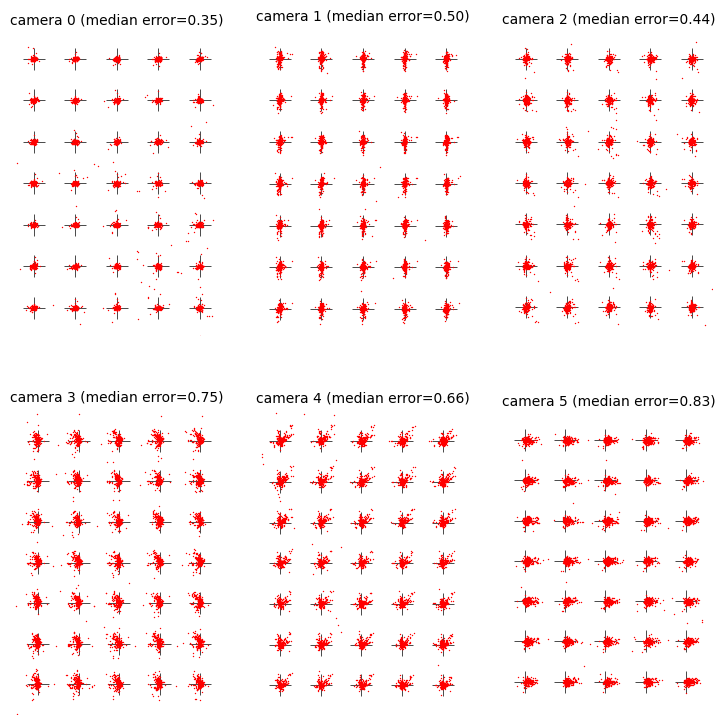

In [4]:
fig, median_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs, all_extrinsics, all_intrinsics, calib_objpoints, calib_poses, inches_per_axis=3)

## Bundle adjustment

In [5]:
adj_extrinsics, adj_intrinsics, adj_calib_poses, use_frames, result = \
    mcc.bundle_adjust(all_calib_uvs, all_extrinsics, all_intrinsics, calib_objpoints, calib_poses, n_frames=5000, ftol=1e-4)

Excluding 199 out of 2130 frames based on an outlier threshold of 3.428785613103967
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.7568e+04                                    7.50e+06    
       1              3         7.8176e+04      1.94e+04       1.02e+02       1.01e+07    
       2              6         4.3648e+04      3.45e+04       1.62e+01       3.31e+06    
       3              7         4.1601e+04      2.05e+03       3.18e+01       4.44e+05    
       4              8         3.7025e+04      4.58e+03       9.18e+00       2.13e+05    
       5              9         3.6771e+04      2.54e+02       1.93e+01       2.27e+05    
       6             10         3.5528e+04      1.24e+03       5.45e+00       1.82e+05    
       7             12         3.5078e+04      4.50e+02       2.40e+00       1.75e+05    
       8             14         3.4917e+04      1.61e+02       8.61e-01       1.77e+05    
      

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.19it/s]


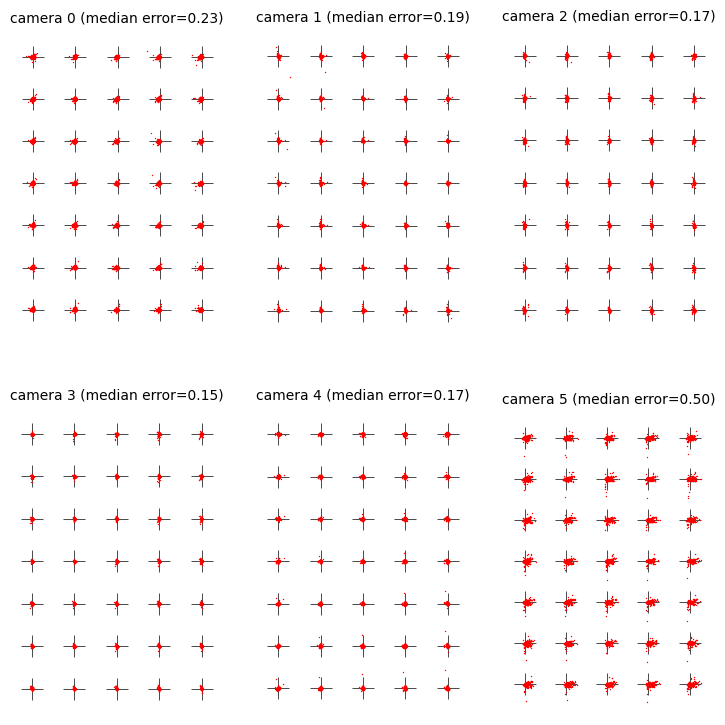

In [6]:
fig, median_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs[:,use_frames], adj_extrinsics, adj_intrinsics, calib_objpoints, adj_calib_poses, inches_per_axis=3)

# Save results

In [13]:
# save for JARVIS
save_path = f'{video_dir}/CalibrationParameters/'
mcc.save_calibration(all_extrinsics, all_intrinsics, camera_names, save_path, save_format='jarvis')

# save for GIMBAL
save_path = f'{video_dir}/camera_params.h5'
mcc.save_calibration(all_extrinsics, all_intrinsics, camera_names, save_path, save_format='gimbal')